In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from geopy.distance import vincenty
import math
import datetime

In [2]:
# PARAMETERS

N = 1 # no of files
degrees_to_radians = math.pi/180.0

In [3]:
# READ
n = 1   
# read an input file into a dataframe
taxiDf = pd.read_csv('TaxiData/%s.txt' %n, names = ['no','time1','lat1','long1']) 
# copy info from next row into current row for easy diff calculations
taxiDf[['time2','lat2','long2']] = taxiDf.shift(-1)[['time1','lat1','long1']]

# some sanity checks
taxiDf.dropna(inplace=True)
taxiDf = taxiDf[taxiDf['time2']>taxiDf['time1']]

# calculate the distance in meters
# manual calculations
# equations from http://www.johndcook.com/blog/python_longitude_latitude/
taxiDf['phi1'] = (90.0 - taxiDf['lat1'])*degrees_to_radians
taxiDf['phi2'] = (90.0 - taxiDf['lat2'])*degrees_to_radians
taxiDf['deltaTheta'] = (taxiDf['long1']-taxiDf['long2'])*degrees_to_radians
taxiDf['cos'] = (np.sin(taxiDf['phi1']) * np.sin(taxiDf['phi2']) * np.cos(taxiDf['deltaTheta']) + np.cos(taxiDf['phi1']) * np.cos(taxiDf['phi2']))
taxiDf['dist'] = np.arccos(taxiDf['cos']) * 6378.1 * 1000

# calculate the time difference 
# calculation using built-in functions
taxiDf['time1'] = pd.to_datetime(taxiDf['time1'])
taxiDf['time2'] = pd.to_datetime(taxiDf['time2'])
taxiDf['timeDelta'] = taxiDf.apply(lambda r: (r['time2']-r['time1']).total_seconds()/60.0, axis=1)

# more sanity checks - speed less than 2500 m/min or 150 km/hr
taxiDf = taxiDf[taxiDf['dist']/taxiDf['timeDelta']<2500]

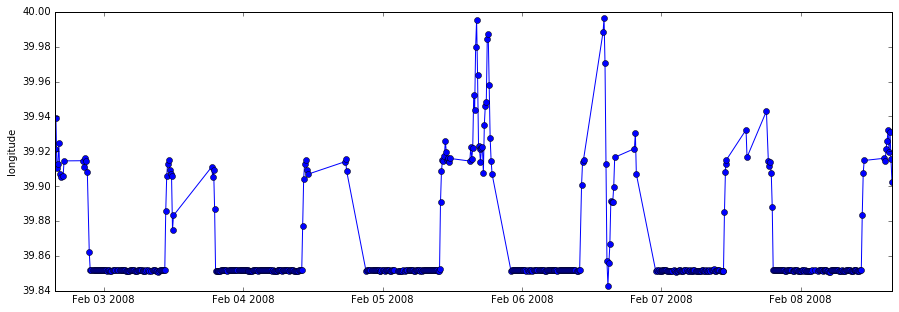

In [4]:
fig, ax = plt.subplots()
ax.plot(taxiDf['time1'],taxiDf['long1'],'o-')
fig.set_size_inches(15,5)
plt.ylabel('longitude')

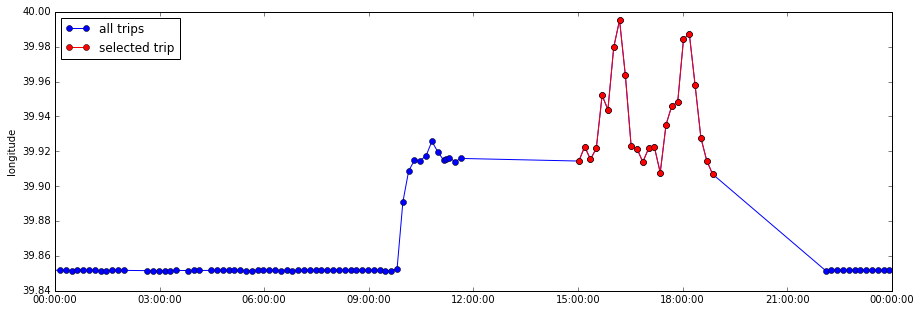

In [5]:
# choose an arbitrary trip
tripStart = taxiDf[(taxiDf['time1']>=datetime.datetime(2008,2,5,15)) & (taxiDf['long1']>39.86)].iloc[0]['time1']
# tripStart: 2008-02-05 15:01:23
tripEnd = taxiDf[(taxiDf['time1']<=datetime.datetime(2008,2,6,0)) & (taxiDf['long1']>39.86)].iloc[-1]['time1']
# tripEnd: 2008-02-05 18:51:20

lat = taxiDf[(taxiDf['time1']>=tripStart)&(taxiDf['time1']<=tripEnd)]['lat1']
lon = taxiDf[(taxiDf['time1']>=tripStart)&(taxiDf['time1']<=tripEnd)]['long1']
time = taxiDf[(taxiDf['time1']>=tripStart)&(taxiDf['time1']<=tripEnd)]['time1']

# show the arbitrary trip
fig, ax = plt.subplots()
ax.plot(taxiDf['time1'],taxiDf['long1'],'o-',time,lon,'o-r')
fig.set_size_inches(15,5)
plt.ylabel('longitude')
plt.xlim(datetime.datetime(2008,2,5),datetime.datetime(2008,2,6))
plt.legend(['all trips','selected trip'],loc='upper left')

In [6]:
# USE SPLREP AND SPLEV TO SMOOTHEN THE TRAJECTORY

from scipy import interpolate
t = (time.astype('int64')/1e9).as_matrix()
int_t = np.linspace(t[0],t[-1],200)

tck_lat = interpolate.splrep(t,lat.as_matrix(),s=0) 
tck_lon = interpolate.splrep(t,lon.as_matrix(),s=0) 

# smoothed lat and lon
int_lat = interpolate.splev(int_t,tck_lat,der=0) 
int_lon = interpolate.splev(int_t,tck_lon,der=0)
# interpolated time
int_t = [datetime.datetime.fromtimestamp(s)+datetime.timedelta(hours=8) for s in int_t]

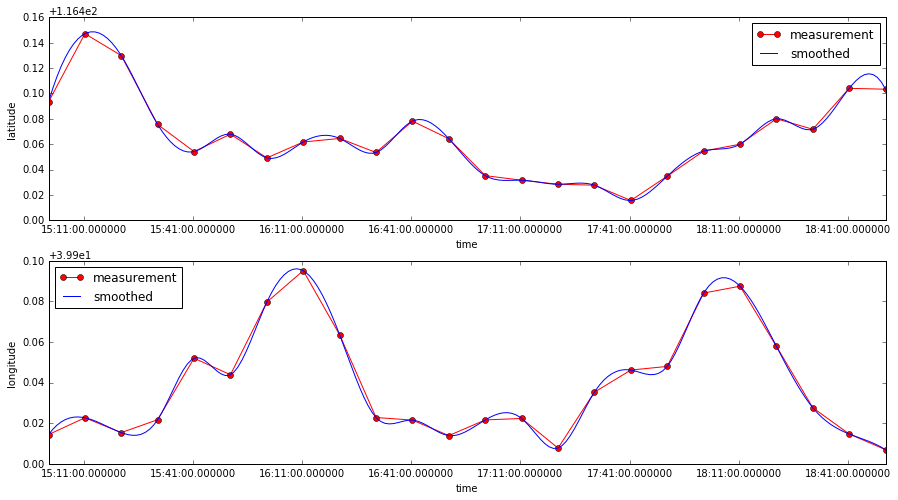

In [38]:
# PLOT THE SMOOTHED TRAJECTORY

fig = plt.figure(figsize=(15, 8)) 

plt.subplot(2,1,1)
plt.plot(time,lat,'r-o',int_t,int_lat,'b-')
plt.ylabel('latitude')
plt.xlabel('time')
plt.legend(['measurement','smoothed'],loc='upper right')
plt.subplot(2,1,2)
plt.plot(time,lon,'r-o',int_t,int_lon,'b-')
plt.ylabel('longitude')
plt.legend(['measurement','smoothed'],loc='upper left')
plt.xlabel('time')